# **FOREWORD**

1. I start off with the competition data without any additional features
2. I train a number of ML models and TABPFNClassifier too
3. I collate their OOF predictions and Hill-Climb them to arrive at a solution blend
4. I use the best public kernel (0.915 LB), akin to others and try and blend the results in step 3 with this kernel to check the LB score


### **COMPETITION DETAILS AND METRIC**

This kernel is for the Playground Season 5-Episode 3 competition with AUC score as the eval metric. <br>
This metric needs to be maximized and this is a **binary classifier** to predict the probability of rainfall, off a HongKong weather dataset.


My adjutant kernel [here](https://www.kaggle.com/code/ravi20076/playgrounds5e3-public-imports-v1) has all background scripts ready-to-use. I can't label this as AutoML, but at least this is a humble step in this regard. I shall load these scripts below, plug and play!

### **REFERENCES**
- https://www.kaggle.com/code/cdeotte/rapids-knn-starter-ensemble-lb-0-956-wow
- https://www.kaggle.com/code/act18l/lb-probing


In this version, I drop the day column as indicated in a comment - let's see the impact!


# **IMPORTS**

In [1]:
%%time 

!pip install -q uv
!uv pip install -q --system -r /kaggle/input/playgrounds5e3-public-imports-v1/req_kaggle.txt

exec( open(f"/kaggle/input/playgrounds5e3-public-imports-v1/myimports.py", "r").read() )
exec( open(f"/kaggle/input/playgrounds5e3-public-imports-v1/myutils.py", "r").read() )
exec( open(f"/kaggle/input/playgrounds5e3-public-imports-v1/training.py", "r").read() )

print()

---> Sklearn = 1.6.1| Pandas = 2.2.3
---> Imports- part 1 done
---> Commencing imports-part2
---> XGBoost = 2.1.4 | LightGBM = 4.5.0
---> Imports- part 2 done
---> Seeding everything

---> Imports done


CPU times: user 9.61 s, sys: 1.74 s, total: 11.4 s
Wall time: 24.3 s


# **CONFIGURATION**

In [2]:
%%time

class CFG:
    """
    Configuration class for parameters and CV strategy for tuning and training
    Some parameters may be unused here as this is a general configuration class
    """;

    # Data preparation:-
    version_nb  = 1
    model_id    = "V1_2"
    model_label = "ML"

    test_req           = False
    test_sample_frac   = 200

    gpu_switch         = "ON" if torch.cuda.is_available() else "OFF"
    state              = 42
    target             = f"rainfall"
    grouper            = f""
    tgt_mapper         = {}

    ip_path            = f"/kaggle/input/playground-series-s5e3"
    op_path            = f"/kaggle/working"
    orig_path          = f""
    data_path          = f""

    dtl_preproc_req    = False
    ftre_plots_req     = True
    ftre_imp_req       = True

    nb_orig            = 0
    orig_all_folds     = False

    # Model Training:-
    pstprcs_oof        = False
    pstprcs_train      = False
    pstprcs_test       = False
    ML                 = True
    test_preds_req     = True

    n_splits           = 5
    n_repeats          = 1
    nbrnd_erly_stp     = 0
    mdlcv_mthd         = 'SKF'
    metric_obj         = 'maximize'

    # Global variables for plotting:-
    grid_specs = {'visible'  : True,
                  'which'    : 'both',
                  'linestyle': '--',
                  'color'    : 'lightgrey',
                  'linewidth': 0.75
                 }

    title_specs = {'fontsize'   : 9,
                   'fontweight' : 'bold',
                   'color'      : '#992600',
                  }

collect()

CPU times: user 206 ms, sys: 991 µs, total: 207 ms
Wall time: 208 ms


0

# **PREPROCESSING**

We load the datasets and fix the CV-folds here <br>
We also impute the solitary null value in the test set column before proceding to model development

In [3]:
%%time 

train  = pd.read_csv(f"{CFG.ip_path}/train.csv", index_col = "id")
test   = pd.read_csv(f"{CFG.ip_path}/test.csv", index_col = "id")
sub_fl = pd.read_csv(f"{CFG.ip_path}/sample_submission.csv", index_col = "id")

PrintColor(f"---> Shapes = {train.shape} {test.shape} {sub_fl.shape}")

Xtrain = train.drop(CFG.target, axis=1)
ytrain = train[CFG.target].astype(np.uint8)
Xtest  = test.copy()
Xtest  = Xtest[Xtrain.columns]

Xtest["winddirection"] = Xtest["winddirection"].fillna( Xtest["winddirection"].ffill())
Xtrain["Source"], Xtest["Source"] = ("Competition" , "Competition")

PrintColor(f"---> Shapes = {Xtrain.shape} {Xtest.shape} {ytrain.shape}\n")

cv    = SKF(shuffle = True, random_state = CFG.state, n_splits = CFG.n_splits)
folds = np.zeros( len(Xtrain) )

for fold_nb, (train_idx, dev_idx) in enumerate( cv.split(Xtrain, ytrain) ):
    folds[dev_idx] = fold_nb

ygrp  = pd.Series(folds, index = train.index.values, name = "fold_nb", dtype = np.int8)

---> Shapes = (2190, 12) (730, 11) (730, 1)
---> Shapes = (2190, 12) (730, 12) (2190,)

CPU times: user 16.9 ms, sys: 5.82 ms, total: 22.7 ms
Wall time: 55.7 ms


# **MODEL TRAINING**

## **IO**

In [4]:
%%time 

Mdl_Master = \
{
    "LGBM1C" : LGBMC(
                    objective         = "binary",
                    eval_metric       = "auc",
                    n_estimators      = 400,
                    learning_rate     = 0.02,
                    max_depth         = 3,
                    colsample_bytree  = 0.95,
                    reg_alpha         = 0.001,
                    reg_lambda        = 0.001,
                    random_state      = CFG.state,
                    verbosity         = -1,
               ),

    "XGB1C" : XGBC(
                    objective         = "binary:logistic",
                    eval_metric       = "auc",
                    n_estimators      = 350,
                    learning_rate     = 0.02,
                    max_depth         = 3,
                    colsample_bytree  = 0.90,
                    colsample_bylevel = 0.80,
                    colsample_bynode  = 0.85,
                    reg_alpha         = 0.001,
                    reg_lambda        = 0.001,
                    random_state      = CFG.state,
                    verbosity         = 0,
                  ),

    "CB1C" : CBC(
                loss_function     = "Logloss",
                eval_metric       = "AUC",
                task_type         = "CPU",
                iterations        = 350,
                learning_rate     = 0.02,
                max_depth         = 3,
                colsample_bylevel = 0.90,
                random_state      = CFG.state,
                verbose           = 0,
                l2_leaf_reg       = 0.25,
                ),

    "HGB1C" : HGBC(
                    loss              = 'log_loss',
                    learning_rate     = 0.025,
                    max_iter          = 300,
                    max_depth         = 5,
                    l2_regularization = 0.40,
                    random_state      = CFG.state,
                  ),

    "RF1C"  : RFC(
                    n_estimators     = 250,
                    max_depth        = 5,
                    min_samples_leaf = 8,
                    random_state     = CFG.state,
                    verbose          = 0,
               ),

    "LR1C"  : LRC(C = 0.05, max_iter = 5_000, random_state = CFG.state),

    "KNN1C" : KNNC(n_neighbors = 125) ,
}

if CFG.gpu_switch == "ON" :
    Mdl_Master["TPFN1C"] = TPFNC(random_state = CFG.state, )
else:
    pass

OOF_Preds = {}
Mdl_Preds = {}
FtreImp   = {}
drop_cols = ["Source", "id", "Id", "Label", CFG.target, "fold_nb", "day"]


CPU times: user 619 µs, sys: 27 µs, total: 646 µs
Wall time: 3.02 ms


## **OFFLINE TRAINING**

  0%|          | 0/7 [00:00<?, ?it/s]



 ============== LGBM1C MODEL TRAINING ============== 




0it [00:00, ?it/s]


---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
LGBM1C Fold0         OOF = 0.921324 | Train = 0.940246 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
LGBM1C Fold1         OOF = 0.847419 | Train = 0.952710 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
LGBM1C Fold2         OOF = 0.868378 | Train = 0.946000 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
LGBM1C Fold3         OOF = 0.903395 | Train = 0.946304 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
LGBM1C Fold4         OOF = 0.889871 | Train = 0.940778 




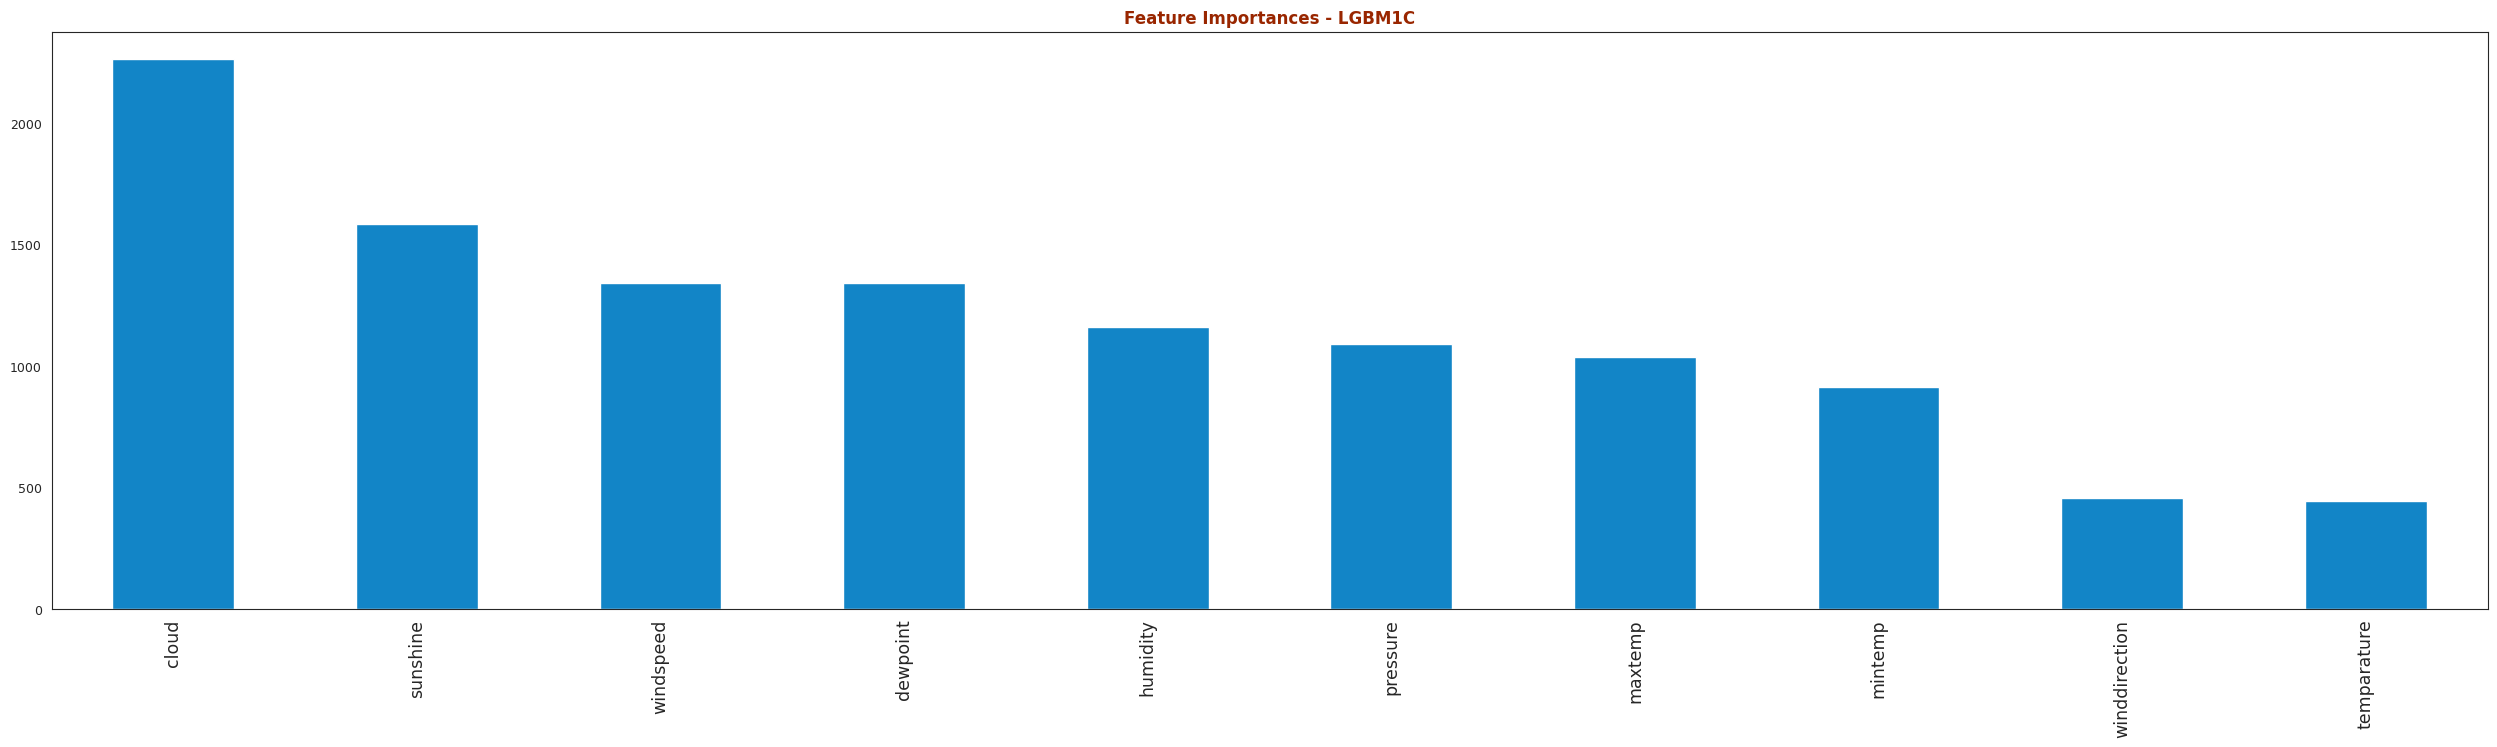



---> 0.886077 +- 0.025940 | OOF
---> 0.945208 +- 0.004525 | Train


 ============== XGB1C MODEL TRAINING ============== 




0it [00:00, ?it/s]


---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
XGB1C Fold0          OOF = 0.922559 | Train = 0.936907 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
XGB1C Fold1          OOF = 0.851066 | Train = 0.950375 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
XGB1C Fold2          OOF = 0.862093 | Train = 0.940817 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
XGB1C Fold3          OOF = 0.907043 | Train = 0.941721 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
XGB1C Fold4          OOF = 0.890741 | Train = 0.936621 




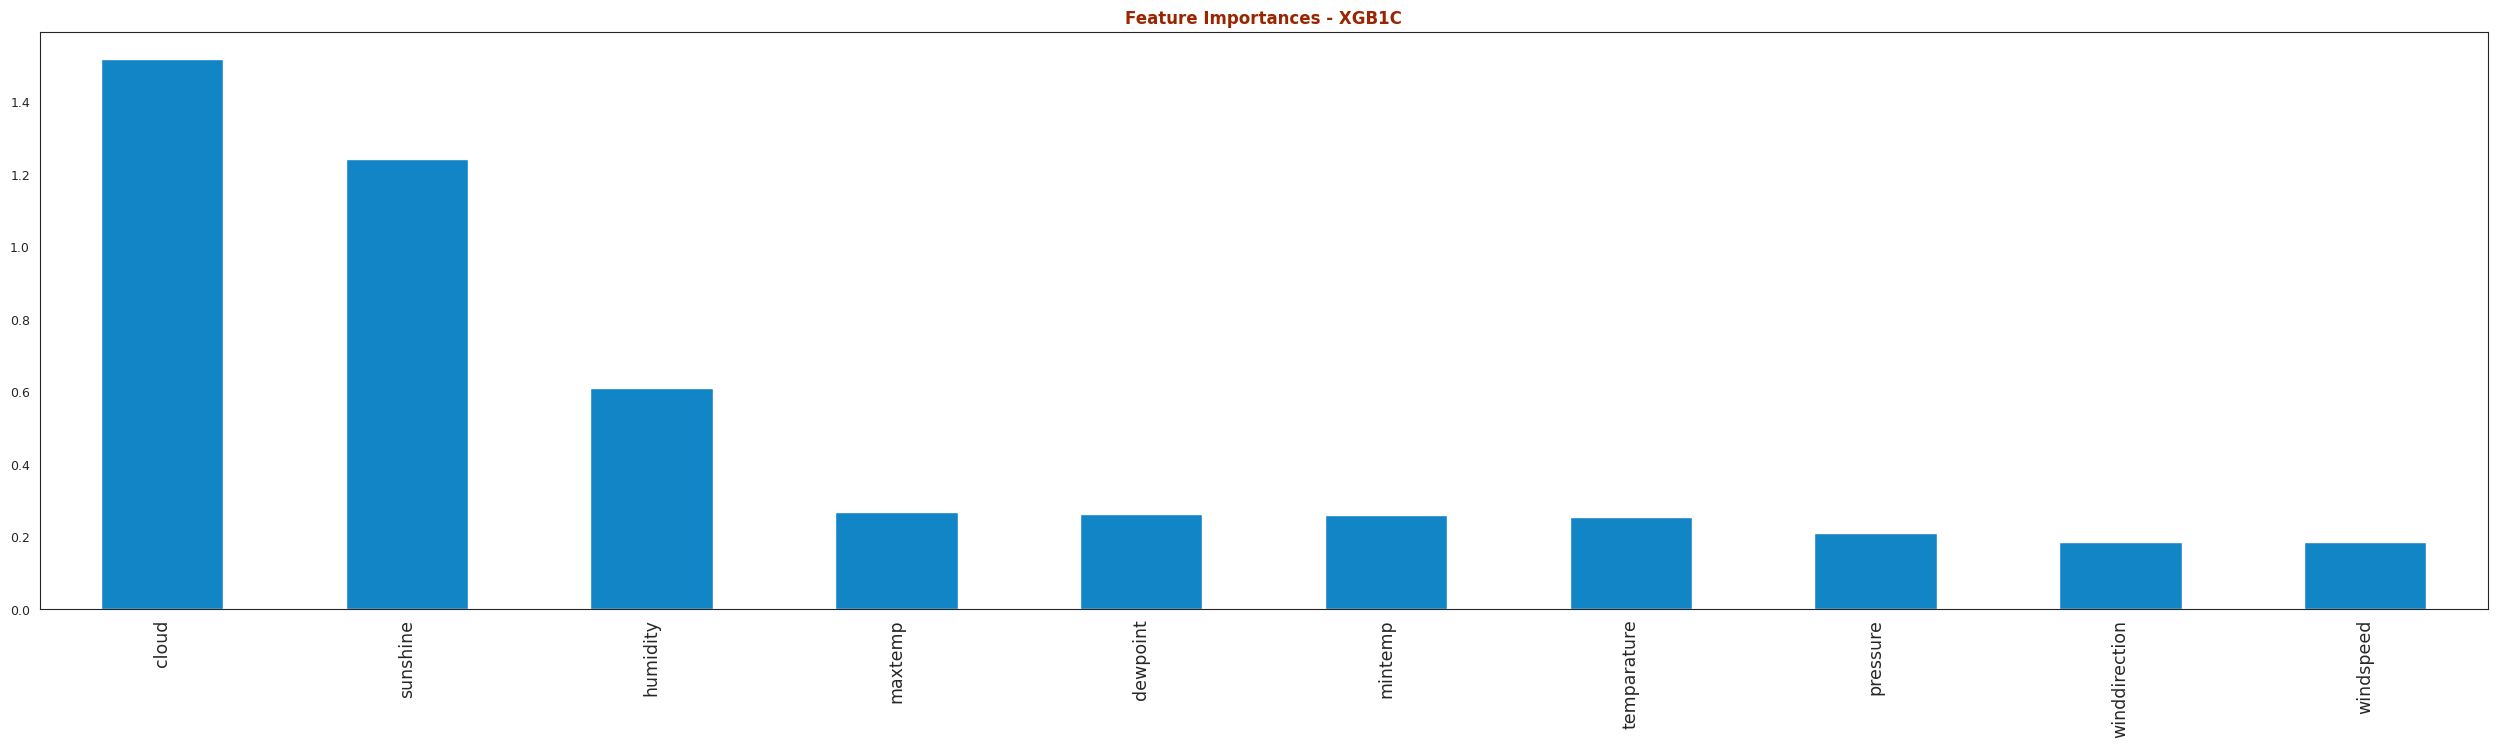



---> 0.886700 +- 0.026800 | OOF
---> 0.941288 +- 0.004979 | Train


 ============== CB1C MODEL TRAINING ============== 




0it [00:00, ?it/s]


---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
CB1C Fold0           OOF = 0.923232 | Train = 0.915827 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
CB1C Fold1           OOF = 0.851403 | Train = 0.930499 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
CB1C Fold2           OOF = 0.873120 | Train = 0.926143 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
CB1C Fold3           OOF = 0.911308 | Train = 0.918785 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
CB1C Fold4           OOF = 0.899242 | Train = 0.921328 




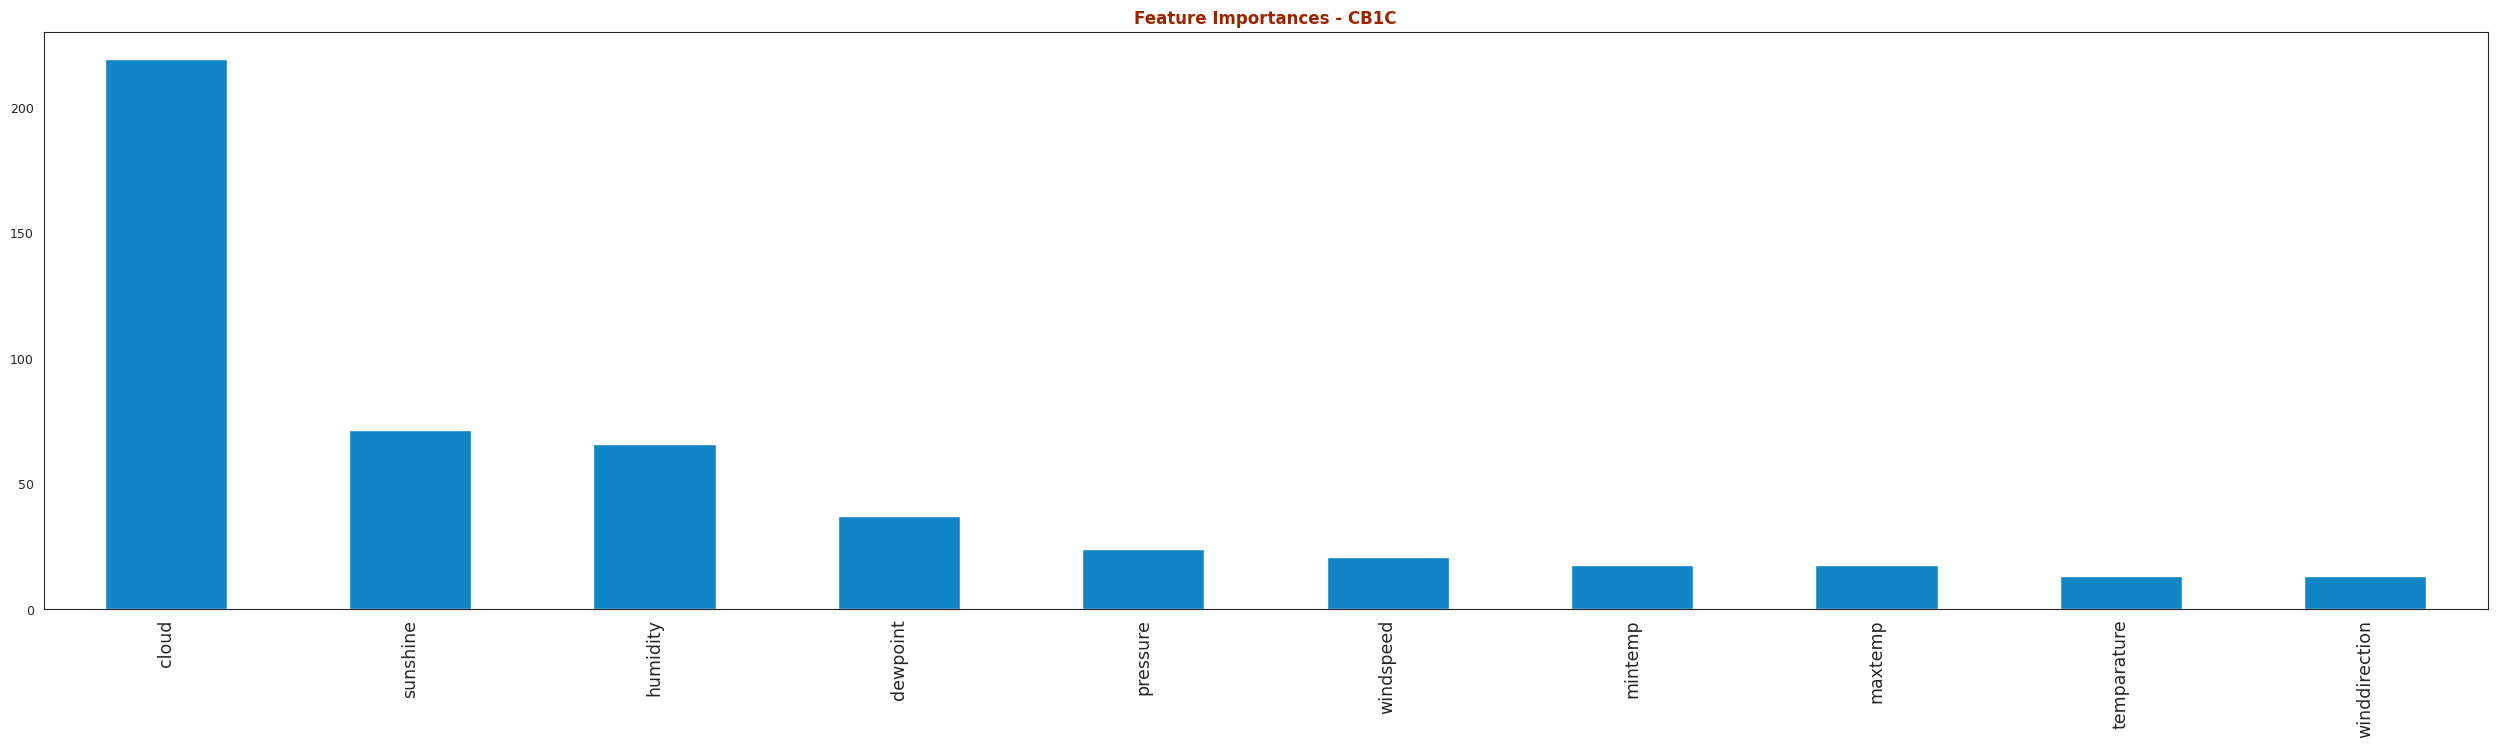



---> 0.891661 +- 0.026095 | OOF
---> 0.922516 +- 0.005234 | Train


 ============== HGB1C MODEL TRAINING ============== 




0it [00:00, ?it/s]


---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
HGB1C Fold0          OOF = 0.910354 | Train = 0.975177 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
HGB1C Fold1          OOF = 0.848962 | Train = 0.981290 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
HGB1C Fold2          OOF = 0.854040 | Train = 0.976550 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
HGB1C Fold3          OOF = 0.894444 | Train = 0.979251 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
HGB1C Fold4          OOF = 0.891246 | Train = 0.975198 




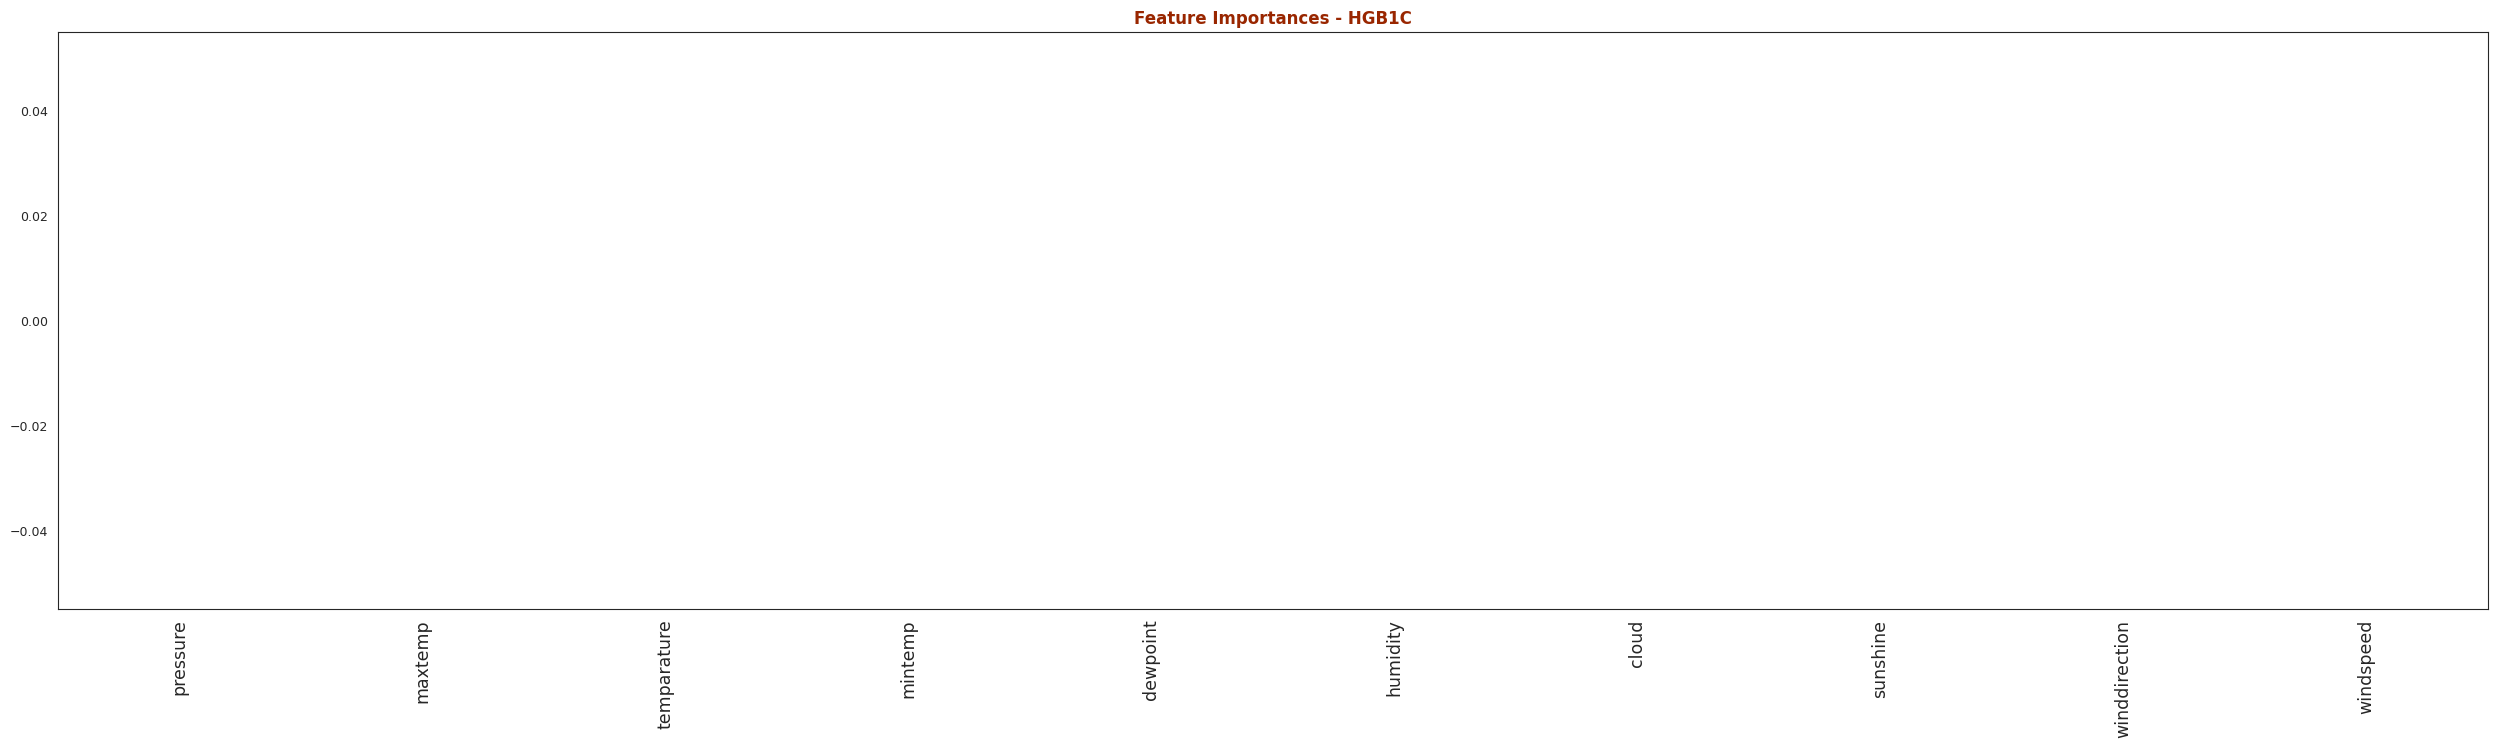



---> 0.879809 +- 0.024056 | OOF
---> 0.977493 +- 0.002409 | Train


 ============== RF1C MODEL TRAINING ============== 




0it [00:00, ?it/s]


---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
RF1C Fold0           OOF = 0.926010 | Train = 0.922234 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
RF1C Fold1           OOF = 0.852834 | Train = 0.934687 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
RF1C Fold2           OOF = 0.869164 | Train = 0.931059 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
RF1C Fold3           OOF = 0.908137 | Train = 0.923139 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
RF1C Fold4           OOF = 0.898990 | Train = 0.924946 




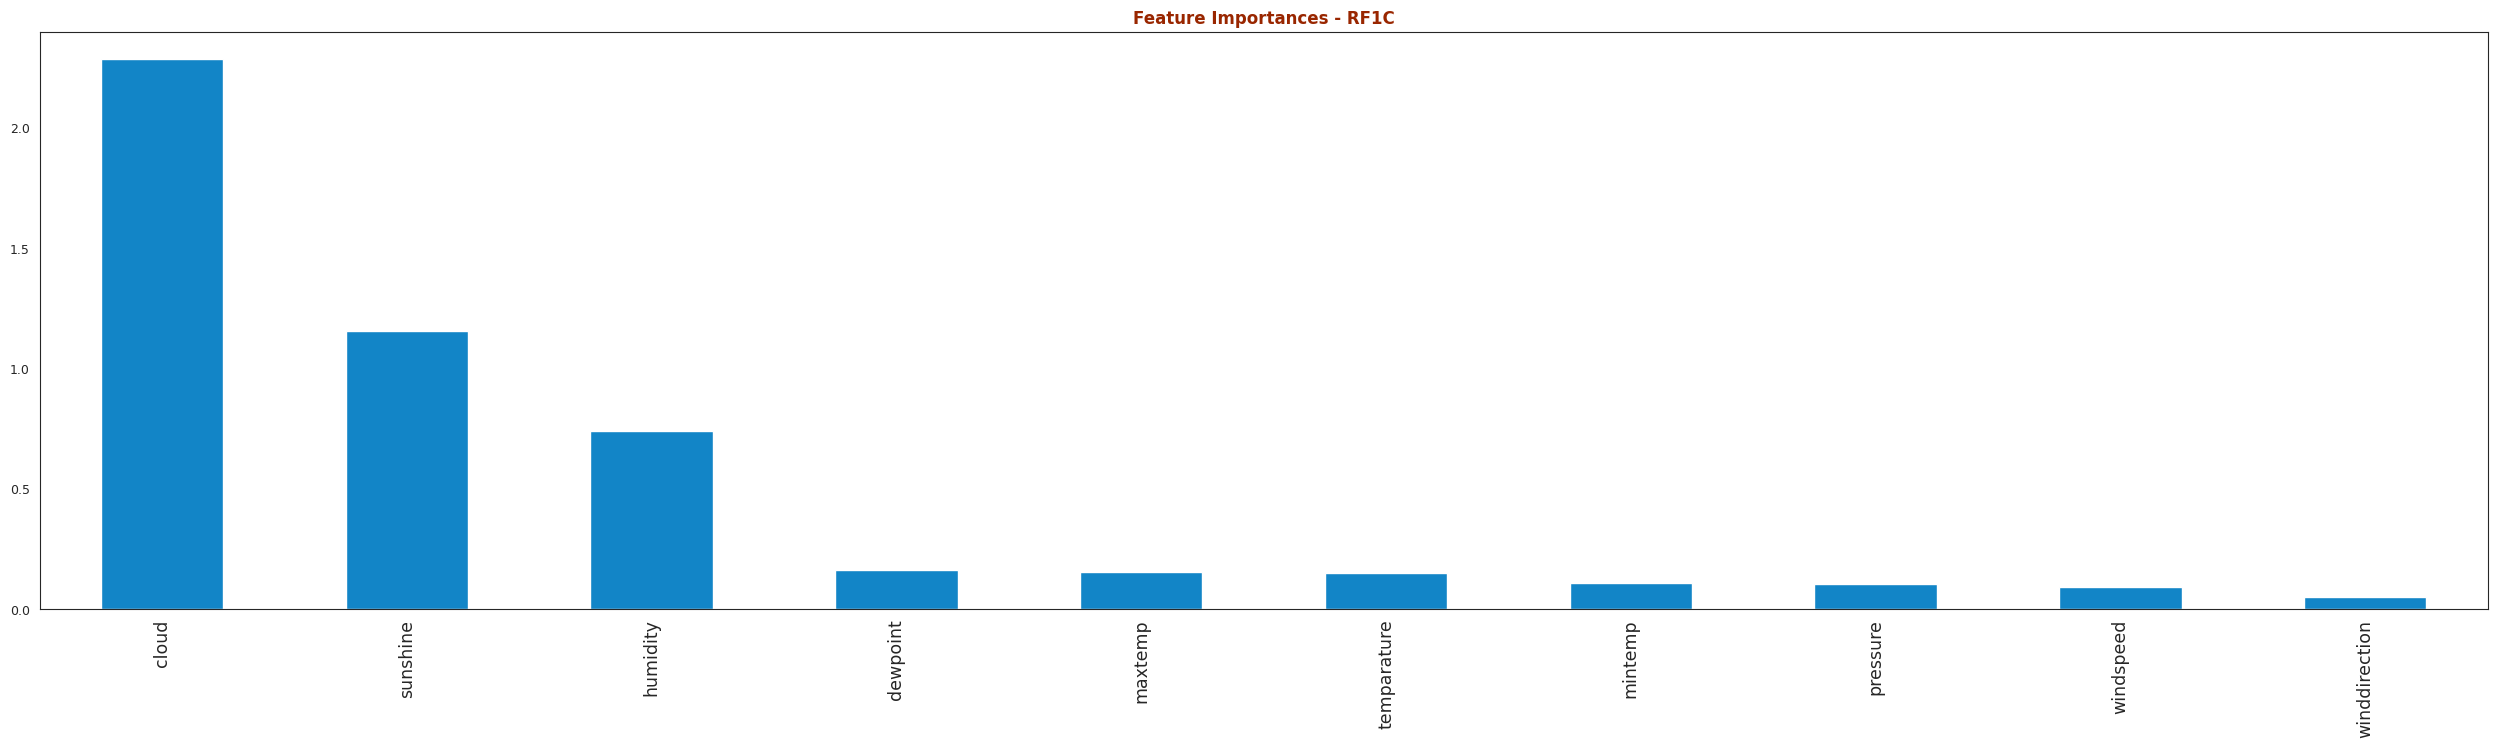



---> 0.891027 +- 0.026521 | OOF
---> 0.927213 +- 0.004841 | Train


 ============== LR1C MODEL TRAINING ============== 




0it [00:00, ?it/s]


---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
LR1C Fold0           OOF = 0.921914 | Train = 0.889927 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
LR1C Fold1           OOF = 0.862374 | Train = 0.904801 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
LR1C Fold2           OOF = 0.879209 | Train = 0.899549 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
LR1C Fold3           OOF = 0.910522 | Train = 0.892182 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
LR1C Fold4           OOF = 0.899270 | Train = 0.896077 




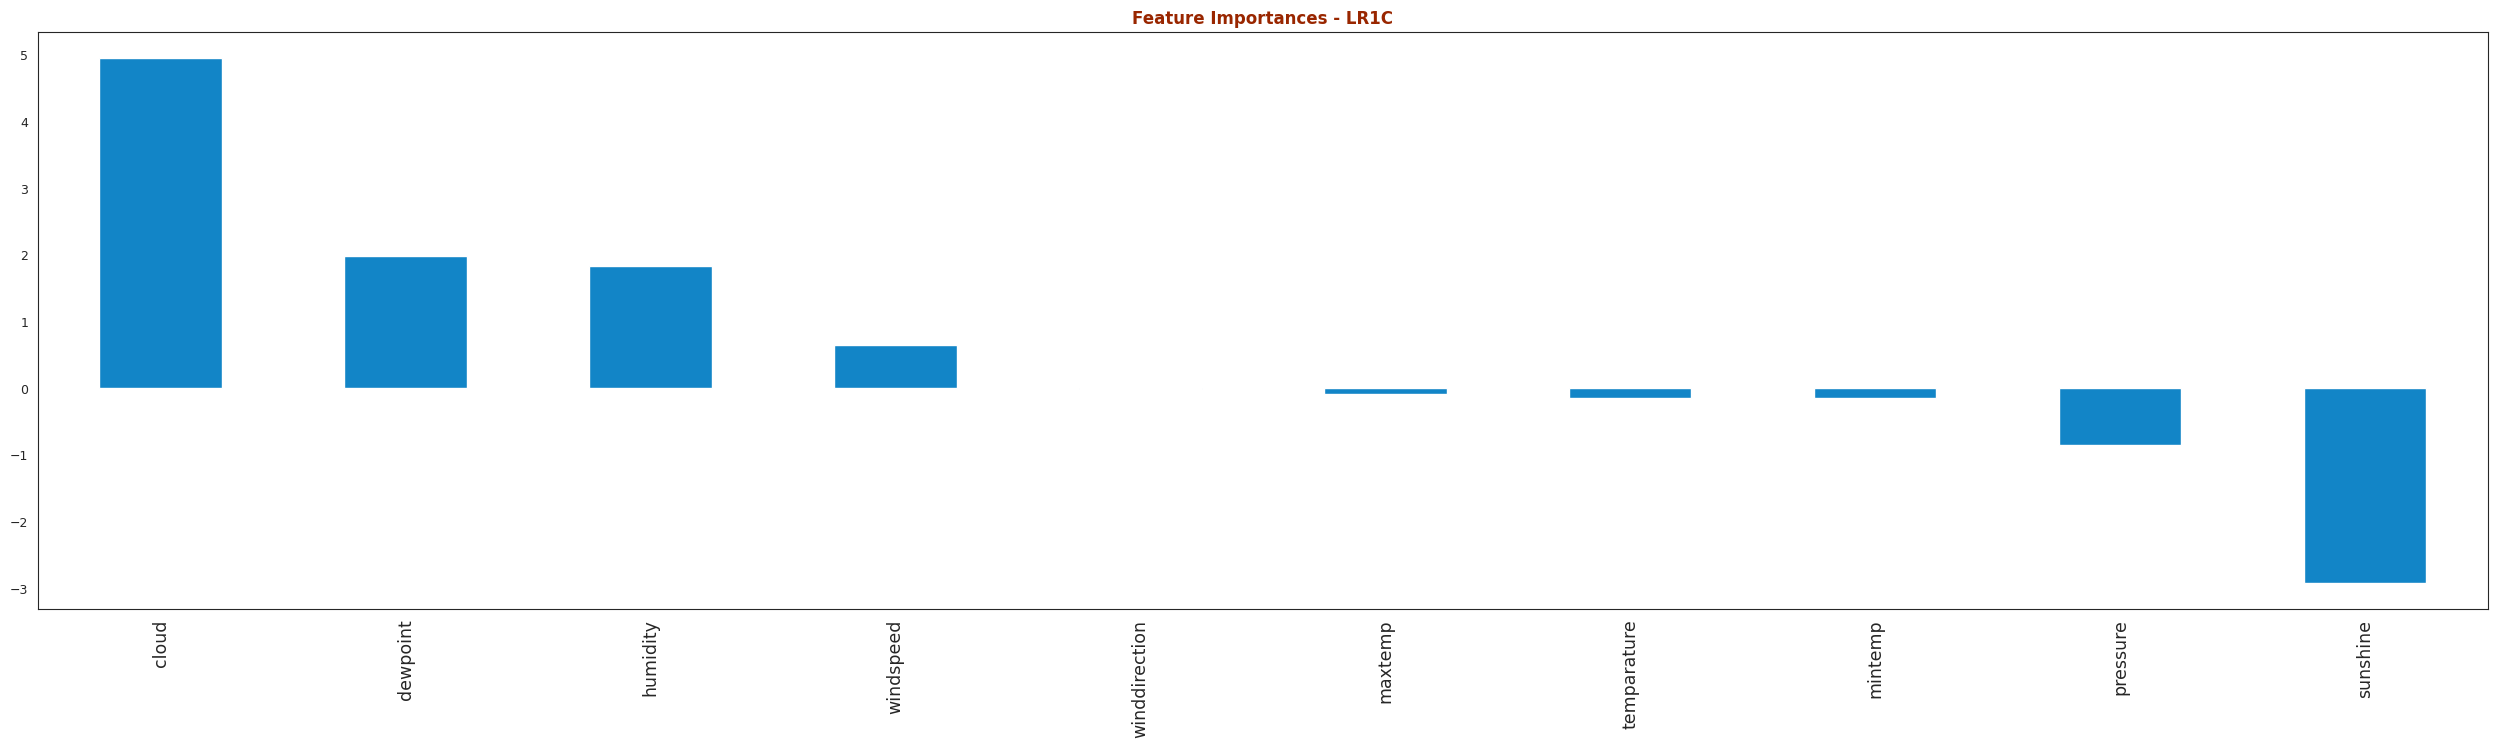



---> 0.894658 +- 0.021432 | OOF
---> 0.896507 +- 0.005296 | Train


 ============== KNN1C MODEL TRAINING ============== 




0it [00:00, ?it/s]


---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
KNN1C Fold0          OOF = 0.917396 | Train = 0.885116 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
KNN1C Fold1          OOF = 0.858361 | Train = 0.901143 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
KNN1C Fold2          OOF = 0.864801 | Train = 0.894287 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
KNN1C Fold3          OOF = 0.891372 | Train = 0.888348 

---> Shapes = (1752, 10) (1752,) -- (438, 10) (438,) -- (730, 10)
KNN1C Fold4          OOF = 0.900028 | Train = 0.890845 




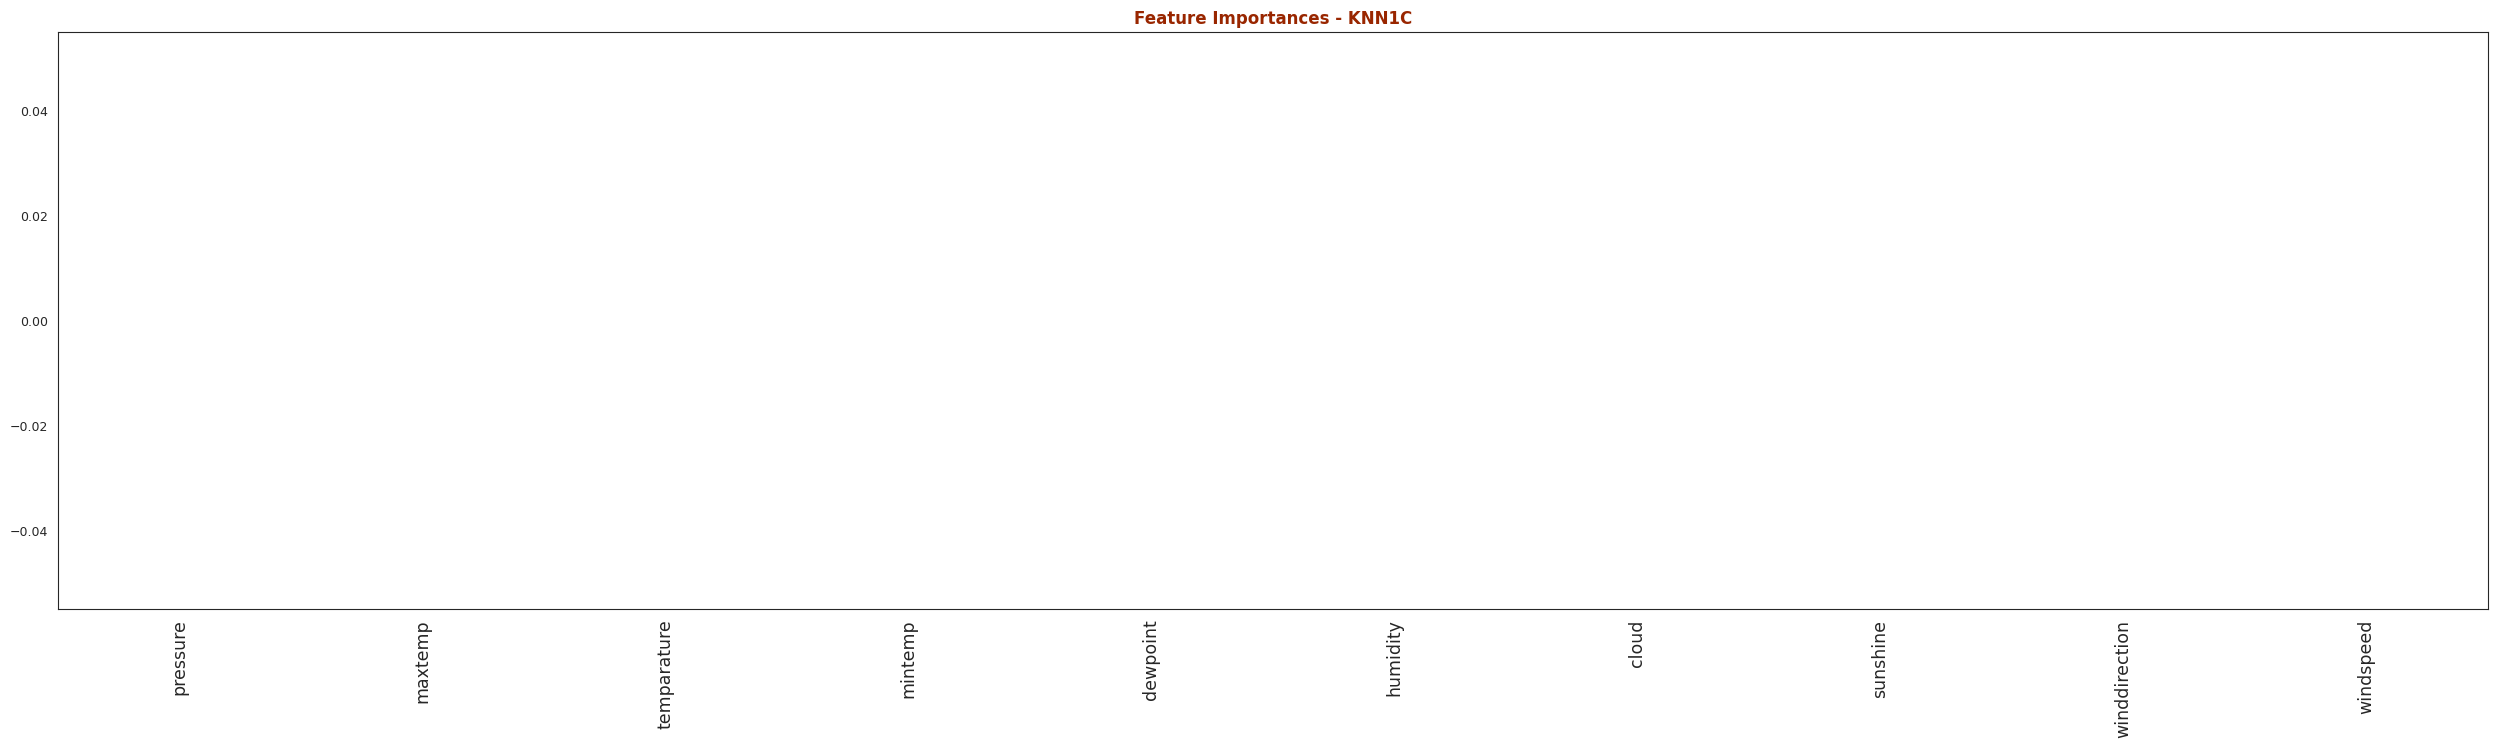



---> 0.886392 +- 0.022018 | OOF
---> 0.891948 +- 0.005493 | Train

CPU times: user 18.4 s, sys: 1.94 s, total: 20.4 s
Wall time: 13.8 s


In [5]:
%%time 

for method, model in tqdm( Mdl_Master.items() ) :

    PrintColor(
        f"\n\n ============== {method} MODEL TRAINING ============== \n\n",
        color = Fore.RED
    )

    md = \
    ModelTrainer(
        problem_type   = "binary",
        es             = CFG.nbrnd_erly_stp,
        target         = CFG.target,
        orig_req       = False,
        orig_all_folds = CFG.orig_all_folds,
        metric_lbl     = "auc",
        drop_cols      = drop_cols,
        pp_preds       = CFG.pstprcs_oof,
    )

    mymodel = Pipeline([("SS", StandardScaler()), ("M", model)])

    _, oof_preds, test_preds, ftreimp, _ =  \
    md.MakeOfflineModel(
        Xtrain,
        ytrain,
        ygrp,
        Xtest,
        clone( mymodel ),
        method,
        test_preds_req   = CFG.test_preds_req,
        ftreimp_plot_req = CFG.ftre_plots_req,
        ntop = 50,
    )

    OOF_Preds[method] = oof_preds
    Mdl_Preds[method] = test_preds
    FtreImp[method]   = ftreimp

    collect()

_ = utils.CleanMemory()
print();

# **ENSEMBLE**

We use a hill-climber blending strategy in-fold to blend the predictions

In [6]:
%%time 

ens_oof_preds = np.zeros( len(Xtrain))
ens_mdl_preds = 0
cv = PDS(ygrp)

oof_preds = pd.DataFrame(OOF_Preds)
mdl_preds = pd.DataFrame(Mdl_Preds)

for fold_nb, (train_idx, dev_idx) in enumerate( cv.split( oof_preds, ytrain) ):
    
    hc = HillClimber()
    dev_preds, preds, _ = \
    hc.DoHillClimb(
        target    = CFG.target, 
        direction = CFG.metric_obj, 
        cutoff    = 100, 
        neg_wgt   = "Y",
        OOF_Preds = oof_preds.iloc[dev_idx],
        Mdl_Preds = mdl_preds.copy() ,
        y         = ytrain.iloc[dev_idx],
    )

    ens_oof_preds[dev_idx] = dev_preds
    ens_mdl_preds += ( preds / CFG.n_splits )

score = utils.ScoreMetric( ytrain.values.flatten(), ens_oof_preds)
PrintColor(
    f"\n---> Ensemble OOF score = {score:,.8f} \n", 
    color = Fore.RED
)

print()
_ = utils.CleanMemory()


----- Data preparation: ------ 



,RF1C,CB1C,XGB1C,LR1C,LGBM1C,KNN1C,HGB1C
Score,0.92601,0.92323,0.92256,0.92191,0.92132,0.91740,0.91035



 ----- Initiating hill-climb ----- 

 1.RF1C                                                Weight =  0.4400       Score = 0.925589
 2.HGB1C                                               Weight = -0.4900       Score = 0.927750
 3.LR1C                                                Weight = -0.2800       Score = 0.928451
 4.XGB1C                                               Weight =  0.1200       Score = 0.928844

----- Data preparation: ------ 



,LR1C,KNN1C,RF1C,CB1C,XGB1C,HGB1C,LGBM1C
Score,0.86237,0.85836,0.85283,0.85140,0.85107,0.84896,0.84742



 ----- Initiating hill-climb ----- 

 1.LR1C                                                Weight =  0.5000       Score = 0.856874
 2.KNN1C                                               Weight =  0.4900       Score = 0.860129
 3.RF1C                                                Weight = -0.4900       Score = 0.861392
 4.CB1C                                                Weight =  0.0700       Score = 0.861700
 5.XGB1C                                               Weight = -0.4400       Score = 0.861981
 6.HGB1C                                               Weight =  0.1500       Score = 0.862149

----- Data preparation: ------ 



,LR1C,CB1C,RF1C,LGBM1C,KNN1C,XGB1C,HGB1C
Score,0.87921,0.87312,0.86916,0.86838,0.86480,0.86209,0.85404



 ----- Initiating hill-climb ----- 

 1.LR1C                                                Weight =  0.5000       Score = 0.876459
 2.XGB1C                                               Weight = -0.4700       Score = 0.881341
 3.HGB1C                                               Weight = -0.3300       Score = 0.884540
 4.CB1C                                                Weight = -0.1200       Score = 0.884848
 5.RF1C                                                Weight =  0.0100       Score = 0.884933
 6.KNN1C                                               Weight = -0.0100       Score = 0.884989

----- Data preparation: ------ 



,CB1C,LR1C,RF1C,XGB1C,LGBM1C,HGB1C,KNN1C
Score,0.91131,0.91052,0.90814,0.90704,0.90340,0.89444,0.89137



 ----- Initiating hill-climb ----- 

 1.LR1C                                                Weight =  0.4700       Score = 0.910073
 2.CB1C                                                Weight =  0.4900       Score = 0.911279
 3.XGB1C                                               Weight = -0.5000       Score = 0.912093
 4.KNN1C                                               Weight = -0.2200       Score = 0.912795
 5.RF1C                                                Weight =  0.2600       Score = 0.913019
 6.HGB1C                                               Weight = -0.1300       Score = 0.913356

----- Data preparation: ------ 



,KNN1C,LR1C,CB1C,RF1C,HGB1C,XGB1C,LGBM1C
Score,0.90003,0.89927,0.89924,0.89899,0.89125,0.89074,0.88987



 ----- Initiating hill-climb ----- 

 1.KNN1C                                               Weight =  0.5000       Score = 0.899355
 2.RF1C                                                Weight =  0.5000       Score = 0.900898
 3.LR1C                                                Weight =  0.2100       Score = 0.901235
 4.XGB1C                                               Weight = -0.0700       Score = 0.901263

---> Ensemble OOF score = 0.89576094 


CPU times: user 16.1 s, sys: 32.8 ms, total: 16.1 s
Wall time: 16.1 s


# **SUBMISSION**

In [7]:
%%time 

sub = \
pd.read_csv(
    f"/kaggle/input/rapids-knn-starter-ensemble-lb-0-956-wow/submission_ensemble.csv"
)[CFG.target].values.flatten()


scl = MinMaxScaler((0, 100))
sub_fl[CFG.target] = \
np.average(
    scl.fit_transform( np.stack([ens_mdl_preds, sub], axis=1) ),
    axis=1,
    weights = [-0.2, 1.2]
)

sub_fl.to_csv("submission.csv", index = True)

oof_preds.index.name = "id"
mdl_preds.index.name = "id"
(
    oof_preds.
    assign(**{"Ensemble" : ens_oof_preds}).
    to_csv(
        f"{CFG.op_path}/OOF_Preds_{CFG.model_label}{CFG.model_id}.csv"
    )
)

(
    mdl_preds.
    assign(**{"Ensemble" : ens_mdl_preds}).
    to_csv(
        f"{CFG.op_path}/Mdl_Preds_{CFG.model_label}{CFG.model_id}.csv"
    )
)

print()
!ls
print()
!head submission.csv
del sub
print()


catboost_info	      __notebook__.ipynb    submission.csv
Mdl_Preds_MLV1_2.csv  OOF_Preds_MLV1_2.csv  xgb_optimize.log

id,rainfall
2190,99.89440562797732
2191,99.59840680631169
2192,101.09045948330122
2193,11.404919883652806
2194,5.520981259271254
2195,76.93562907797605
2196,84.69135859893566
2197,99.58904326969461
2198,96.06343187604104

CPU times: user 36.6 ms, sys: 29.2 ms, total: 65.8 ms
Wall time: 318 ms
